In [157]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.linear_model import Ridge

In [191]:
def lorenz_derivatives(state, t, sigma=10.0, rho=28.0, beta=8.0/3.0):
    """Compute time derivatives [dx/dt, dy/dt, dz/dt] for the Lorenz system."""
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

In [192]:
def generate_lorenz_data(
    initial_state=[1.0, 1.0, 1.0],
    tmax=25.0,
    dt=0.01,
    sigma=10.0,
    rho=28.0,
    beta=8.0/3.0
):
    """
    Numerically integrate Lorenz equations x'(t), y'(t), z'(t) using odeint.
    Returns: 
       t_vals: array of time points
       sol   : array shape [num_steps, 3] of [x(t), y(t), z(t)]
    """
    num_steps = int(tmax / dt)
    t_vals = np.linspace(0, tmax, num_steps)
    sol = odeint(lorenz_derivatives, initial_state, t_vals, args=(sigma, rho, beta))
    return t_vals, sol

In [193]:
def scale_spectral_radius(W, target_radius=0.95):
    eigvals = np.linalg.eigvals(W)
    radius = np.max(np.abs(eigvals))
    if radius == 0:
        return W
    return (W / radius) * target_radius

In [194]:
class BaselineESN3D:
    """
    A baseline Echo State Network that handles:
      - 3D input (x,y,z)
      - 3D output (x(t+1), y(t+1), z(t+1))"
    """
    def __init__(self,
                 reservoir_size=300,
                 spectral_radius=0.95,
                 input_scale=1.0,
                 leaking_rate=0.8,
                 ridge_alpha=1e-6,
                 seed=42):
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.seed = seed

        np.random.seed(self.seed)
        # Initialize W with small random values (mean=0, variance=0.01)
        W = np.random.randn(reservoir_size, reservoir_size) * 0.1
        W = scale_spectral_radius(W, self.spectral_radius)
        self.W = W

        np.random.seed(self.seed + 1)
        # Initialize input weights in range [-input_scale, input_scale]
        self.W_in = (np.random.rand(reservoir_size, 3) - 0.5) * 2.0 * self.input_scale
        
        # Readout: shape (3, reservoir_size+1) -> 3D output
        self.W_out = None
        self.reset_state()

    def reset_state(self):
        self.x = np.zeros(self.reservoir_size)

    def _update(self, u):
        """
        Single time-step ESN update:
          x(t+1) = (1-alpha)*x(t) + alpha*tanh( W*x(t) + W_in*u(t) )
        where u is R^3 (the Lorenz state).
        """
        pre_activation = self.W @ self.x + self.W_in @ u
        x_new = np.tanh(pre_activation)
        alpha = self.leaking_rate
        self.x = (1.0 - alpha) * self.x + alpha * x_new

    def collect_states(self, inputs, discard=100):
        """
        Run reservoir on 'inputs' (shape [T, 3]), discarding the first 'discard' steps.
        Returns: states [T-discard, reservoir_size]
        """
        self.reset_state()
        states = []
        for t in range(len(inputs)):
            self._update(inputs[t])
            states.append(self.x.copy())
        states = np.array(states)
        return states[discard:], states[:discard]
    
    def fit_readout(self, train_input, train_target, discard=100):
        """
        Teacher forcing for single-step:
          - input(t) = [x(t), y(t), z(t)]
          - target(t) = [x(t+1), y(t+1), z(t+1)]
        We collect states(t), then solve a multi-output ridge regression:
          W_out * [x(t); 1] ~ target(t+1).
        """
        states_use, _ = self.collect_states(train_input, discard=discard)
        targets_use = train_target[discard:]  # shape [T-discard, 3]

        # Augment states with bias
        X_aug = np.hstack([states_use, np.ones((states_use.shape[0], 1))])  # shape [T-discard, N+1]

        ridge_reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        ridge_reg.fit(X_aug, targets_use)
        self.W_out = ridge_reg.coef_

    def predict(self, inputs):
        """
        Single-step-ahead inference on test data:
        For each inputs[t], we update reservoir, then read out 3D prediction.
        """
        preds = []
        for t in range(len(inputs)):
            self._update(inputs[t])
            x_aug = np.concatenate([self.x, [1.0]])
            out = self.W_out @ x_aug
            preds.append(out)
        return np.array(preds)
    
    def autoregressive_predict(self, initial_input, num_steps):
      """
      Autoregressive multi-step forecasting for num_steps
      """
      preds = []
      current_input = initial_input.copy()
    
      for _ in range(num_steps):
          self._update(current_input)
          x_aug = np.concatenate([self.x, [1.0]])
          out = self.W_out @ x_aug
          preds.append(out)
          current_input = out
      
      return np.array(preds)

In [195]:
class CycleReservoir3D(BaselineESN3D):
    """
    Cyclic Reservoir for 3D -> 3D Lorenz.
    - reservoir_size, spectral_radius, input_scale, leaking_rate, ridge_alpha as in baseline
    """
    def __init__(self,
                 reservoir_size=300,
                 spectral_radius=0.95,
                 input_scale=1.0,
                 leaking_rate=0.8,
                 ridge_alpha=1e-6,
                 seed=42):
        
        super().__init__()
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.seed = seed

        np.random.seed(self.seed)
        # Build cycle adjacency: W[i,(i+1)%N] = 1
        W = np.zeros((reservoir_size, reservoir_size))
        for i in range(reservoir_size):
            j = (i+1) % reservoir_size
            W[i, j] = 1.0

        W = scale_spectral_radius(W, self.spectral_radius)
        self.W = W

        np.random.seed(self.seed + 1)
        # Initialize input weights in range [-input_scale, input_scale]
        self.W_in = (np.random.rand(self.reservoir_size, 3) - 0.5) * 2.0 * self.input_scale

In [196]:
class SparseESN3D(BaselineESN3D):
    """
    Sparse ESN for 3D->3D Lorenz.
    - connectivity: fraction of non_zero entries in W
    - reservoir_size, spectral_radius, input_scale, leaking_rate, ridge_alpha as in baseline
    """
    def __init__(self,
                 reservoir_size=300,
                 spectral_radius=0.95,
                 connectivity=0.05,  # fraction of non-zero entries in W
                 input_scale=1.0,
                 leaking_rate=0.8,
                 ridge_alpha=1e-6,
                 seed=42):
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius
        self.connectivity = connectivity
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.seed = seed

        np.random.seed(self.seed)
        # Initialize W with small random values (mean=0, variance=0.01)
        W = np.random.randn(reservoir_size, reservoir_size) * 0.1
        # Create a boolean sparsity mask
        mask = (np.random.rand(reservoir_size, reservoir_size) < self.connectivity)
        W = W * mask
        W = scale_spectral_radius(W, self.spectral_radius)
        self.W = W

        np.random.seed(self.seed + 1)
        # Initialize input weights in range [-input_scale, input_scale]
        self.W_in = (np.random.rand(self.reservoir_size, 3) - 0.5) * 2.0 * self.input_scale

In [197]:
class HFR3D(BaselineESN3D):
    """
    Hierarchical Fractal Reservoir for 3D -> 3D Lorenz.
    - num_levels: number of fractal expansions
    - base_module_size: dimension of the base module
    - branching_factor: number of modules to replicate at each level
    - intra_scale, inter_scale: spectral radii for intra-block, inter-block
    - input_scale, leaking_rate, ridge_alpha as in baseline
    """
    def __init__(self,
                 num_levels=2,
                 base_module_size=50,
                 branching_factor=2,
                 intra_scale=0.95,
                 inter_scale=0.8,
                 input_scale=1.0,
                 leaking_rate=0.8,
                 ridge_alpha=1e-6,
                 seed=42):
        
        super().__init__()
        self.num_levels = num_levels
        self.base_module_size = base_module_size
        self.branching_factor = branching_factor
        self.intra_scale = intra_scale
        self.inter_scale = inter_scale
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.seed = seed

        # Build fractal-like reservoir matrix W
        self.W = self._build_fractal_W()
        self.reservoir_size = self.W.shape[0]

        np.random.seed(self.seed + 1)
        # Initialize input weights in range [-input_scale, input_scale]
        self.W_in = (np.random.rand(self.reservoir_size, 3) - 0.5) * 2.0 * self.input_scale
        

    def _build_fractal_W(self):
        np.random.seed(self.seed)
        # Base module
        base_size = self.base_module_size
        # Initialize base_block with small random values (mean=0, variance=0.01)
        base_block = np.random.randn(base_size, base_size) * 0.1
        base_block = scale_spectral_radius(base_block, self.intra_scale)

        current_W = base_block
        current_size = base_size

        for level in range(2, self.num_levels+1):
            n_mods = self.branching_factor
            block_size = current_size
            new_size = block_size * n_mods

            new_W = np.zeros((new_size, new_size))
            # replicate block along diagonal
            for m in range(n_mods):
                r0 = m * block_size
                new_W[r0:r0+block_size, r0:r0+block_size] = current_W
            
            # ring-style cross connections
            for m in range(n_mods):
                r0 = m*block_size
                c0 = ((m+1) % n_mods) * block_size
                cross_block = np.random.randn(block_size, block_size) * 0.1
                cross_block = scale_spectral_radius(cross_block, self.inter_scale)
                new_W[r0:r0+block_size, c0:c0+block_size] = cross_block

            current_W = new_W
            current_size = new_size

        return current_W


In [198]:
tmax = 50.01
dt = 0.01
t_vals, lorenz_trajectory = generate_lorenz_data(
    initial_state=[1.0, 1.0, 1.0], 
    tmax=tmax,
    dt=dt,
    sigma=10.0,
    rho=28.0,
    beta=8.0/3.0
)

In [199]:
# # Normalize data
# data_min = lorenz_trajectory.min(axis=0)
# data_max = lorenz_trajectory.max(axis=0)
# lorenz_trajectory = (lorenz_trajectory - data_min) / (data_max - data_min)

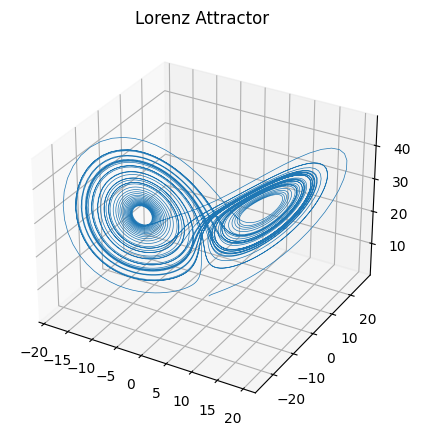

In [200]:
# Visualizing Lorenz attractor
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection='3d')
ax.plot(lorenz_trajectory[:, 0], lorenz_trajectory[:, 1], lorenz_trajectory[:, 2], lw=0.5)
ax.set_title("Lorenz Attractor")
plt.show()

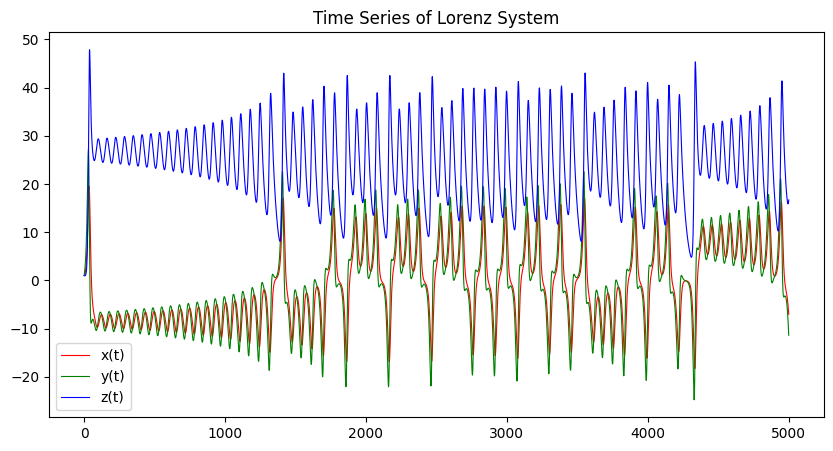

In [201]:
t = np.linspace(0, len(lorenz_trajectory), len(lorenz_trajectory))

plt.figure(figsize=(10, 5))
plt.plot(t, lorenz_trajectory[:, 0], label='x(t)', color='r', lw=0.8)
plt.plot(t, lorenz_trajectory[:, 1], label='y(t)', color='g', lw=0.8)
plt.plot(t, lorenz_trajectory[:, 2], label='z(t)', color='b', lw=0.8)

plt.title("Time Series of Lorenz System")
plt.legend()
plt.show()

In [202]:
# Prepare single-step data: input(t) = [x(t), y(t), z(t)], target(t)=[x(t+1), y(t+1), z(t+1)]
inputs = lorenz_trajectory[:-1]
targets = lorenz_trajectory[1:]

In [203]:
data_size = len(lorenz_trajectory)-1
train_size = 3500
train_input = inputs[:train_size]
train_target = targets[:train_size]
test_input = inputs[train_size:]
test_target = inputs[train_size:]
print(f"Total samples: {data_size}, train size: {train_size}, test size: {len(test_input)}")

Total samples: 5000, train size: 3500, test size: 1500


## Teacher-forced Single-step Forecasting

In [204]:
# Define horizons to test
all_horizons = list(range(10, 1501, 10))
horizons = [200, 400, 600, 800, 1000, 1200, 1500]

In [205]:
def evaluate_teacher_forced(model, test_input, test_target, horizons):
    """
    Evaluate model performance over multiple prediction horizons for Teacher-forced Single-step Forecasting
    """
    horizon_rmse = {}
    all_preds = model.predict(test_input)
    
    for horizon in horizons:
        preds = all_preds[:horizon]
        targets = test_target[:horizon]
        mse = np.mean((preds - targets)**2, axis=0)
        rmse = np.sqrt(np.mean(mse))
        horizon_rmse[horizon] = rmse

    return horizon_rmse, np.array(all_preds)

In [206]:
# Baseline ESN
esn = BaselineESN3D(
    reservoir_size=400,
    spectral_radius=0.95,
    input_scale=1.0,
    leaking_rate=0.8,
    ridge_alpha=1e-6,
    seed=42
)
discard_esn = 100
esn.fit_readout(train_input, train_target, discard=discard_esn)
esn_rmse, esn_preds = evaluate_teacher_forced(esn, test_input, test_target, all_horizons)

In [207]:
# Cycle Reservoir
cycle_res = CycleReservoir3D(
    reservoir_size=400,
    spectral_radius=0.95,
    input_scale=1.0,
    leaking_rate=0.8,
    ridge_alpha=1e-6,
    seed=42
)
discard_cycle_res = 100
cycle_res.fit_readout(train_input, train_target, discard=discard_cycle_res)
cycle_res_rmse, cycle_res_preds = evaluate_teacher_forced(cycle_res, test_input, test_target, all_horizons)

In [208]:
# Sparse ESN
sparse_esn = SparseESN3D(
    reservoir_size=400,
    spectral_radius=0.95,
    connectivity=0.05,
    input_scale=1.0,
    leaking_rate=0.8,
    ridge_alpha=1e-6,
    seed=42
)
discard_sparse_esn = 100
sparse_esn.fit_readout(train_input, train_target, discard=discard_sparse_esn)
sparse_esn_rmse, sparse_esn_preds = evaluate_teacher_forced(sparse_esn, test_input, test_target, all_horizons)

In [209]:
# HFR
hfr = HFR3D(
    num_levels=4,          
    base_module_size=50, 
    branching_factor=2,  
    intra_scale=0.95,
    inter_scale=0.05,
    input_scale=1.0,
    leaking_rate=0.8,
    ridge_alpha=1e-3,
    seed=42
)
discard_hfr = 100
hfr.fit_readout(train_input, train_target, discard=discard_hfr)
hfr_rmse, hfr_preds = evaluate_teacher_forced(hfr, test_input, test_target, all_horizons)

In [210]:
# Print results
print("\nRMSE for Different Prediction Horizons:")
print("-" * 70)
print(f"{'Horizon':<10} {'ESN':<15} {'CycleRes':<15} {'SparseESN':<15} {'HFR':<15}")
print("-" * 70)

for horizon in horizons:
    print(f"{horizon:<10} {esn_rmse[horizon]:<15.6f} {cycle_res_rmse[horizon]:<15.6f} {sparse_esn_rmse[horizon]:<15.6f} {hfr_rmse[horizon]:<15.6f}")


RMSE for Different Prediction Horizons:
----------------------------------------------------------------------
Horizon    ESN             CycleRes        SparseESN       HFR            
----------------------------------------------------------------------
200        0.732727        0.705434        0.680674        0.664403       
400        0.677733        0.662515        0.650472        0.645130       
600        0.691632        0.683402        0.675238        0.670979       
800        1.337080        1.061787        2.609262        0.715834       
1000       25.846643       18.270847       12.886460       2.302735       
1200       23.595449       16.680217       11.767004       2.151070       
1500       21.107765       14.922065       10.531104       1.950577       


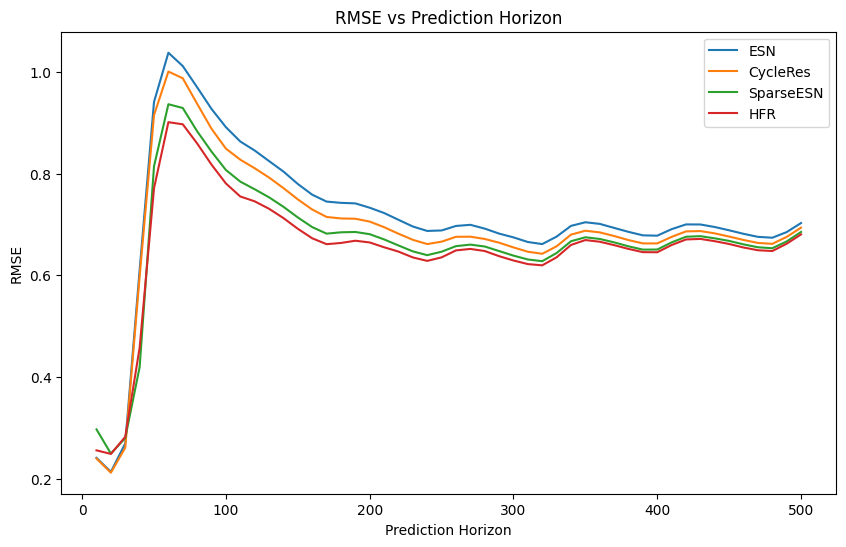

In [211]:
# Plot RMSE vs Horizon
plot_len=500
steps = list(range(10, plot_len+1, 10))

plt.figure(figsize=(10, 6))
plt.plot(steps, [esn_rmse[s] for s in steps], label='ESN')
plt.plot(steps, [cycle_res_rmse[s] for s in steps], label='CycleRes')
plt.plot(steps, [sparse_esn_rmse[s] for s in steps], label='SparseESN')
plt.plot(steps, [hfr_rmse[s] for s in steps], label='HFR')
plt.xlabel('Prediction Horizon')
plt.ylabel('RMSE')
plt.title('RMSE vs Prediction Horizon')
plt.legend()
plt.show()

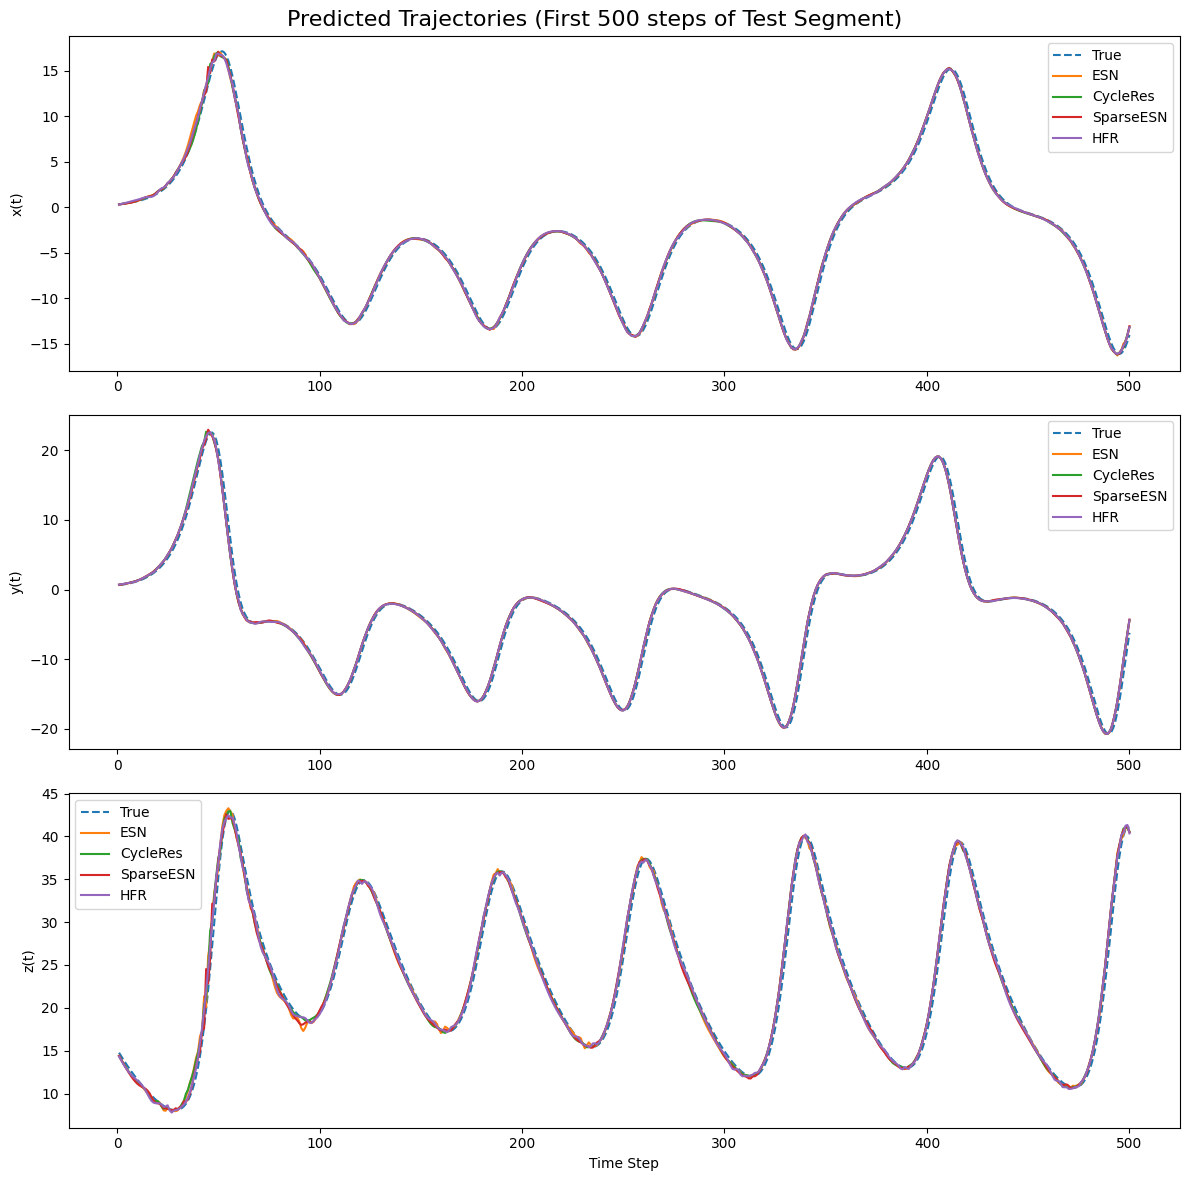

In [212]:
steps = list(range(1, plot_len+1))

# Create subplots for x, y, z dimensions
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

dims = ['x(t)', 'y(t)', 'z(t)']
for i in range(3):
    axes[i].plot(steps, test_target[:plot_len, i], label='True', linestyle='dashed')
    axes[i].plot(steps, esn_preds[:plot_len, i], label='ESN')
    axes[i].plot(steps, cycle_res_preds[:plot_len, i], label='CycleRes')
    axes[i].plot(steps, sparse_esn_preds[:plot_len, i], label='SparseESN')
    axes[i].plot(steps, hfr_preds[:plot_len, i], label='HFR')
    axes[i].set_ylabel(dims[i])
    axes[i].legend()

# Set common X-axis label
axes[-1].set_xlabel('Time Step')
fig.suptitle('Predicted Trajectories (First 500 steps of Test Segment)', fontsize=16)

# Adjust layout
plt.tight_layout()
plt.show()

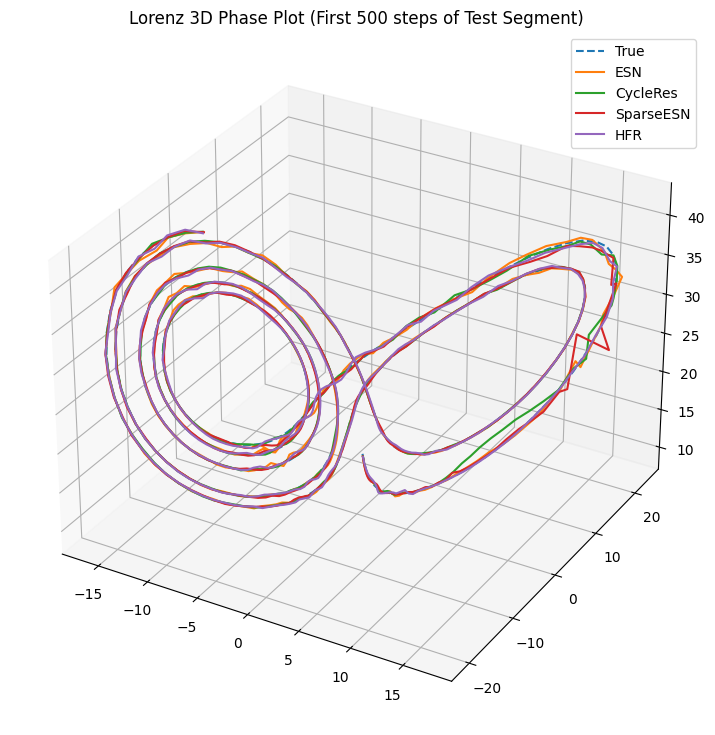

In [213]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection='3d')
ax.plot(test_target[:plot_len,0], test_target[:plot_len,1], test_target[:plot_len,2], label='True', linestyle='dashed')
ax.plot(esn_preds[:plot_len,0], esn_preds[:plot_len,1], esn_preds[:plot_len,2], label='ESN')
ax.plot(cycle_res_preds[:plot_len,0], cycle_res_preds[:plot_len,1], cycle_res_preds[:plot_len,2], label='CycleRes')
ax.plot(sparse_esn_preds[:plot_len,0], sparse_esn_preds[:plot_len,1], sparse_esn_preds[:plot_len,2], label='SparseESN')
ax.plot(hfr_preds[:plot_len,0], hfr_preds[:plot_len,1], hfr_preds[:plot_len,2], label='HFR')
ax.set_title('Lorenz 3D Phase Plot (First 500 steps of Test Segment)')
ax.legend()
plt.show()

## Autoregressive Multi-step Forecasting

In [214]:
# Define horizons to test
all_horizons = list(range(10, 1501, 10))
horizons = [200, 400, 600, 800, 1000, 1200, 1500]

In [215]:
def evaluate_autoregressive(model, initial_input, test_target, horizons):
    """
    Evaluate model performance over multiple prediction horizons for Autoregressive Multi-step Forecasting
    """
    horizon_rmse = {}
    num_steps = len(test_target)
    all_preds = model.autoregressive_predict(initial_input, num_steps)
    
    for horizon in horizons:
        preds = all_preds[:horizon]
        targets = test_target[:horizon]
        mse = np.mean((preds - targets)**2, axis=0)
        rmse = np.sqrt(np.mean(mse))
        horizon_rmse[horizon] = rmse

    return horizon_rmse, np.array(all_preds)

In [216]:
initial_state = train_input[-1]

In [217]:
# Baseline ESN
esn = BaselineESN3D(
    reservoir_size=400,
    spectral_radius=0.95,
    input_scale=1.0,
    leaking_rate=0.8,
    ridge_alpha=1e-6,
    seed=42
)
discard_esn = 100
esn.fit_readout(train_input, train_target, discard=discard_esn)
esn_rmse, esn_preds = evaluate_autoregressive(esn, initial_state, test_target, all_horizons)

In [218]:
# Cycle Reservoir
cycle_res = CycleReservoir3D(
    reservoir_size=400,
    spectral_radius=0.95,
    input_scale=1.0,
    leaking_rate=0.8,
    ridge_alpha=1e-6,
    seed=42
)
discard_cycle_res = 100
cycle_res.fit_readout(train_input, train_target, discard=discard_cycle_res)
cycle_res_rmse, cycle_res_preds = evaluate_autoregressive(cycle_res, initial_state, test_target, all_horizons)

In [219]:
# Sparse ESN
sparse_esn = SparseESN3D(
    reservoir_size=400,
    spectral_radius=0.95,
    connectivity=0.05,
    input_scale=1.0,
    leaking_rate=0.8,
    ridge_alpha=1e-6,
    seed=42
)
discard_sparse_esn = 100
sparse_esn.fit_readout(train_input, train_target, discard=discard_sparse_esn)
sparse_esn_rmse, sparse_esn_preds = evaluate_autoregressive(sparse_esn, initial_state, test_target, all_horizons)

In [220]:
# HFR
hfr = HFR3D(
    num_levels=4,          
    base_module_size=50, 
    branching_factor=2,  
    intra_scale=0.95,
    inter_scale=0.05,
    input_scale=1.0,
    leaking_rate=0.8,
    ridge_alpha=1e-3,
    seed=42
)
discard_hfr = 100
hfr.fit_readout(train_input, train_target, discard=discard_hfr)
hfr_rmse, hfr_preds = evaluate_autoregressive(hfr, initial_state, test_target, all_horizons)

In [221]:
# Print results
print("\nRMSE for Different Prediction Horizons:")
print("-" * 70)
print(f"{'Horizon':<10} {'ESN':<15} {'CycleRes':<15} {'SparseESN':<15} {'HFR':<15}")
print("-" * 70)

for horizon in horizons:
    print(f"{horizon:<10} {esn_rmse[horizon]:<15.6f} {cycle_res_rmse[horizon]:<15.6f} {sparse_esn_rmse[horizon]:<15.6f} {hfr_rmse[horizon]:<15.6f}")


RMSE for Different Prediction Horizons:
----------------------------------------------------------------------
Horizon    ESN             CycleRes        SparseESN       HFR            
----------------------------------------------------------------------
200        153.196449      60.882296       11.843266       17.313064      
400        173.903794      43.979744       12.379228       13.557198      
600        179.831483      36.406511       11.770358       13.836196      
800        183.310519      32.031004       11.718173       22.258077      
1000       184.894467      28.965100       11.327987       37.591853      
1200       185.845202      26.493057       10.473783       45.455922      
1500       186.999179      23.919096       9.939296        52.136705      


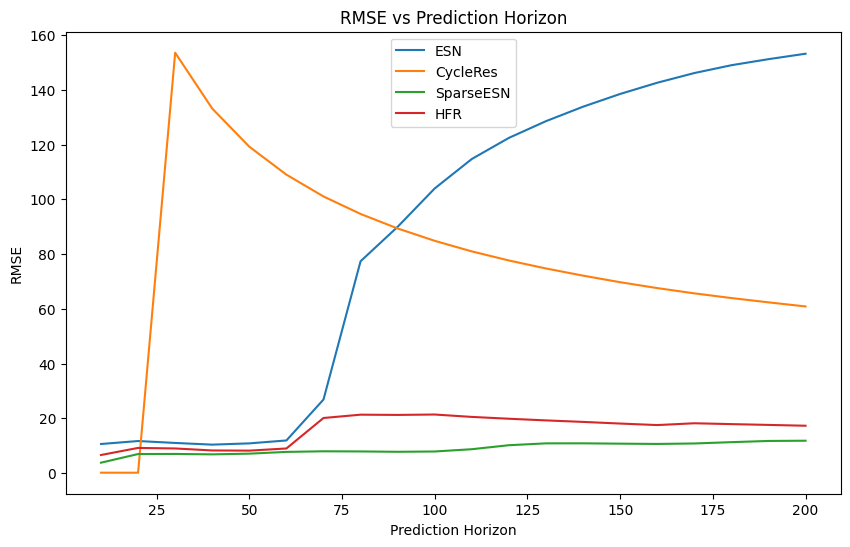

In [222]:
# Plot RMSE vs Horizon
plot_len=200
steps = list(range(10, plot_len+1, 10))

plt.figure(figsize=(10, 6))
plt.plot(steps, [esn_rmse[s] for s in steps], label='ESN')
plt.plot(steps, [cycle_res_rmse[s] for s in steps], label='CycleRes')
plt.plot(steps, [sparse_esn_rmse[s] for s in steps], label='SparseESN')
plt.plot(steps, [hfr_rmse[s] for s in steps], label='HFR')
plt.xlabel('Prediction Horizon')
plt.ylabel('RMSE')
plt.title('RMSE vs Prediction Horizon')
plt.legend()
plt.show()

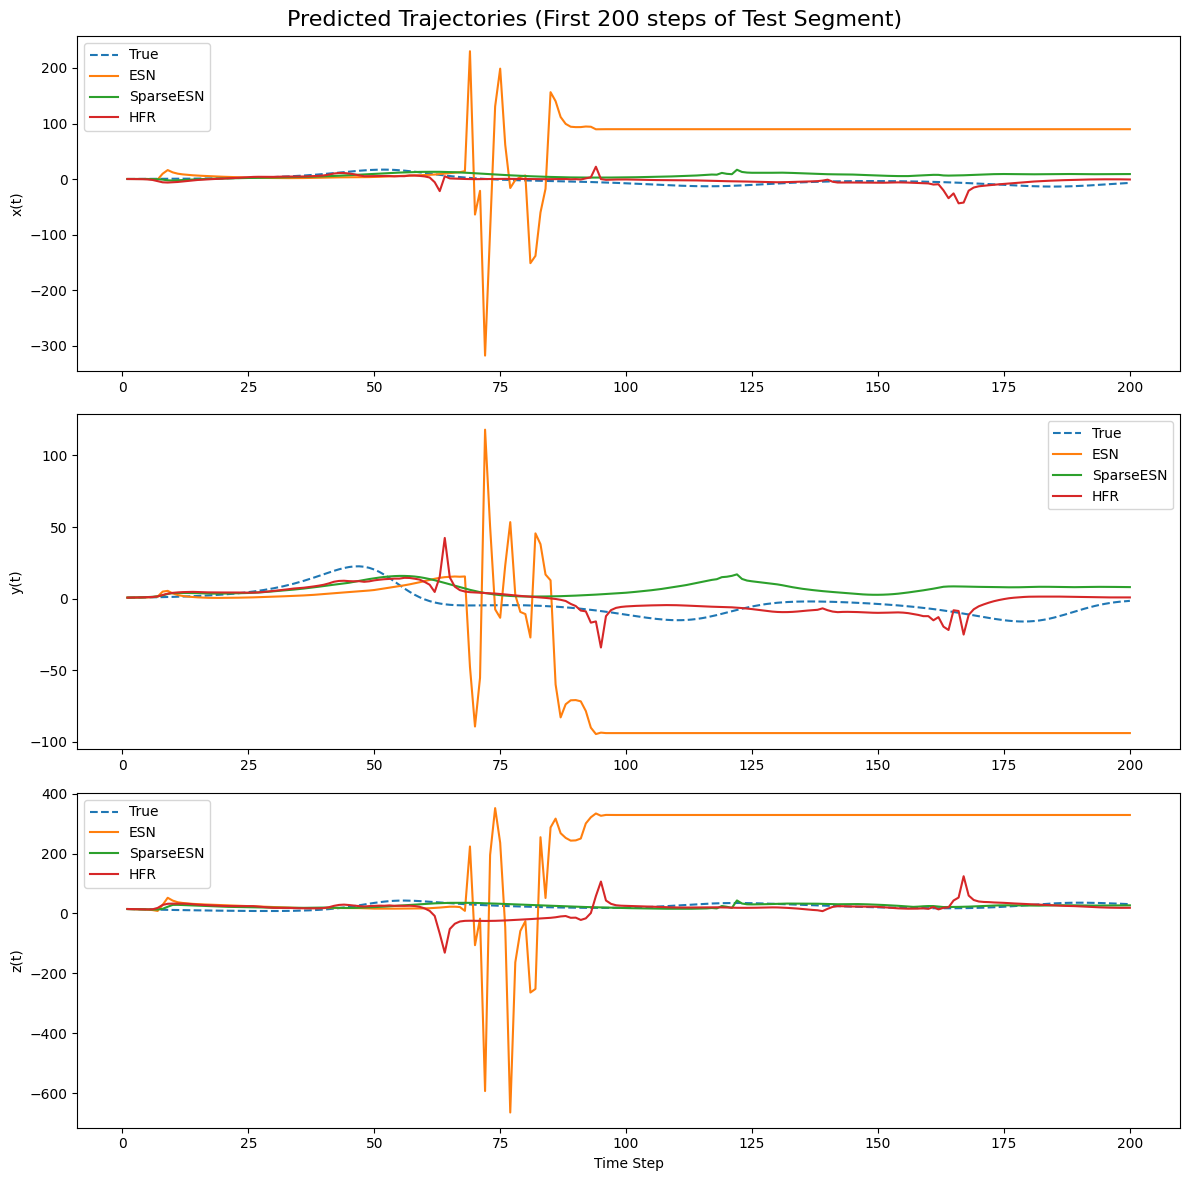

In [223]:
steps = list(range(1, plot_len+1))

# Create subplots for x, y, z dimensions
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

dims = ['x(t)', 'y(t)', 'z(t)']
for i in range(3):
    axes[i].plot(steps, test_target[:plot_len, i], label='True', linestyle='dashed')
    axes[i].plot(steps, esn_preds[:plot_len, i], label='ESN')
    # axes[i].plot(steps, cycle_res_preds[:plot_len, i], label='CycleRes')
    axes[i].plot(steps, sparse_esn_preds[:plot_len, i], label='SparseESN')
    axes[i].plot(steps, hfr_preds[:plot_len, i], label='HFR')
    axes[i].set_ylabel(dims[i])
    axes[i].legend()

# Set common X-axis label
axes[-1].set_xlabel('Time Step')
fig.suptitle('Predicted Trajectories (First 200 steps of Test Segment)', fontsize=16)

# Adjust layout
plt.tight_layout()
plt.show()